In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/realwaste.zip"  # Update with your file path
extract_dir = "/content/dataset"  # Destination directory to unzip files

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Dataset unzipped successfully!")


Dataset unzipped successfully!


#Clean and Restructure the Dataset

In [3]:
import os
from PIL import Image

dataset_path = "/content/dataset/realwaste/RealWaste"

def clean_images(directory):
    """
    Removes corrupted images from the dataset.
    """
    for class_name in ['Compostable', 'Trash', 'Recyclable']:
        class_path = os.path.join(directory, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)  # Check if image can be opened
                img.verify()  # Verify image integrity
            except (IOError, SyntaxError):
                print(f"Corrupted image found: {img_path} - Removing...")
                os.remove(img_path)

clean_images(dataset_path)
print("Image cleaning completed.")

Image cleaning completed.


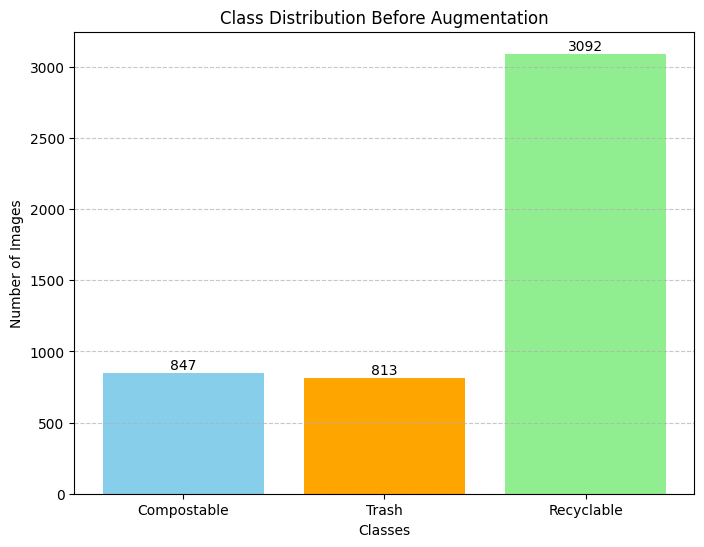

In [4]:
import os
import matplotlib.pyplot as plt

# Path to the dataset directory
data_dir = "/content/dataset/realwaste/RealWaste"

# Class names
classes = ["Compostable", "Trash", "Recyclable"]

# Count the number of images in each class
class_counts = {}
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    class_counts[cls] = len(os.listdir(class_dir))

# Plot the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=["skyblue", "orange", "lightgreen"])
plt.title("Class Distribution Before Augmentation")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the count above each bar
for i, count in enumerate(class_counts.values()):
    plt.text(i, count + 5, str(count), ha="center", va="bottom", fontsize=10)

plt.show()

#Address Class Imbalance (Oversampling and Augmentation)
Using data augmentation for the minority classes (Trash and Compostable) to balance the dataset

In [5]:
import os
import random
from PIL import Image
from torchvision import transforms

# Input and output directory
input_dir = "/content/dataset/realwaste/RealWaste"

# Data augmentation pipeline
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),           # Horizontal Flip
    transforms.RandomRotation(20),               # Random Rotation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random Cropping
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color Jitter
    transforms.ToTensor(),
    transforms.ToPILImage()                      # Convert back to PIL for saving
])

def augment_images(input_dir, target_count):
    """
    Augment images for the minority classes to reach the target count.

    Parameters:
    - input_dir: Path to the dataset directory.
    - target_count: Number of images desired in each class after augmentation.
    """
    for cls in ['Trash', 'Compostable']:  # Only augment minority classes
        class_dir = os.path.join(input_dir, cls)
        images = [img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]

        print(f"Augmenting class '{cls}'... Original count: {len(images)}")
        existing_count = len(images)

        # Perform augmentation until we reach the target count
        while len(images) < target_count:
            img_name = random.choice(images)  # Randomly choose an existing image
            img_path = os.path.join(class_dir, img_name)
            image = Image.open(img_path).convert("RGB")

            # Apply augmentation
            augmented_image = augmentations(image)

            # Save augmented image
            new_img_name = f"aug_{len(images)}_{img_name}"
            augmented_image.save(os.path.join(class_dir, new_img_name))
            images.append(new_img_name)  # Add to the list to track progress

        print(f"Class '{cls}' augmented to {len(images)} images.")

# Set target count (equal to the Recyclable class: 3092)
target_count = 3092
augment_images(input_dir, target_count)
print("Data augmentation for minority classes completed successfully!")

Augmenting class 'Trash'... Original count: 813
Class 'Trash' augmented to 3092 images.
Augmenting class 'Compostable'... Original count: 847
Class 'Compostable' augmented to 3092 images.
Data augmentation for minority classes completed successfully!


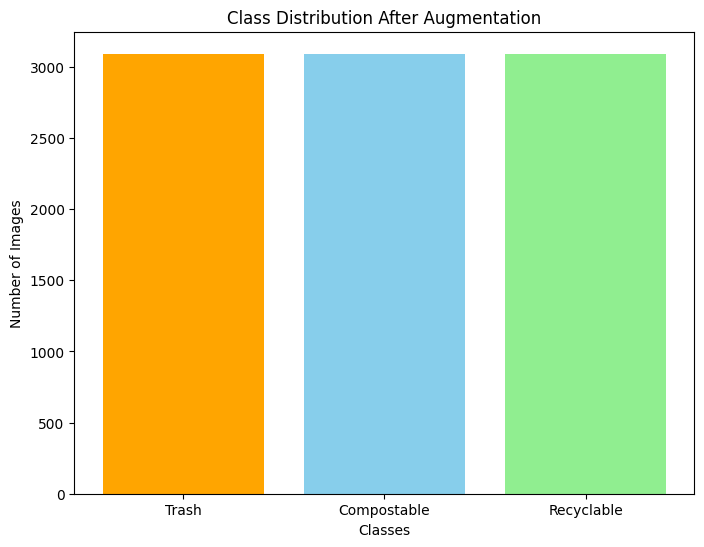

In [6]:
import os
import matplotlib.pyplot as plt

# Count images in each class
class_counts = {}
for cls in ['Trash', 'Compostable', 'Recyclable']:
    class_path = os.path.join(input_dir, cls)
    class_counts[cls] = len([img for img in os.listdir(class_path) if img.endswith(('.jpg', '.png', '.jpeg'))])

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=["orange", "skyblue", "lightgreen"])
plt.title("Class Distribution After Augmentation")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

#Split the Dataset
Split the dataset into train (70%), validation (15%), and test (15%).

In [8]:
#new code
import os
import shutil
import re
from sklearn.model_selection import train_test_split

# Paths to input and output directories
input_dir = "/content/dataset/realwaste/RealWaste"
output_dir = "/content/dataset/processed_uniform"

# Create output directories
for split in ['train', 'val', 'test']:
    for cls in ['Trash', 'Compostable', 'Recyclable']:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

def split_uniformly(input_dir, output_dir, test_size=0.15, val_size=0.15):
    """
    Splits images into train, validation, and test sets uniformly across subcategories.

    Parameters:
    - input_dir: Path to the original dataset.
    - output_dir: Path to save the processed dataset.
    - test_size: Fraction of images for the test set.
    - val_size: Fraction of images for the validation set.
    """
    for cls in ['Trash', 'Compostable', 'Recyclable']:
        class_path = os.path.join(input_dir, cls)
        images = os.listdir(class_path)

        # Group images by subcategories (assume subcategory is part of the filename)
        subcategory_groups = {}
        for img in images:
            # Extract subcategory using regex (modify as per filename format)
            subcategory = re.findall(r'^[a-zA-Z]+', img)  # Get leading text
            subcategory = subcategory[0] if subcategory else "unknown"

            if subcategory not in subcategory_groups:
                subcategory_groups[subcategory] = []
            subcategory_groups[subcategory].append(img)

        # Perform the split for each subcategory
        train_files, val_files, test_files = [], [], []
        for subcat, imgs in subcategory_groups.items():
            train_temp, test_temp = train_test_split(imgs, test_size=test_size, random_state=42)
            train_split, val_split = train_test_split(train_temp, test_size=val_size/(1-test_size), random_state=42)

            train_files.extend(train_split)
            val_files.extend(val_split)
            test_files.extend(test_temp)

        # Move files to respective directories
        for split, files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
            for img in files:
                src = os.path.join(class_path, img)
                dst = os.path.join(output_dir, split, cls, img)
                shutil.copy(src, dst)

        print(f"Class '{cls}': Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}")

# Perform the uniform split
split_uniformly(input_dir, output_dir, test_size=0.15, val_size=0.15)
print("Data split completed with uniform distribution across subcategories!")

Class 'Trash': Train=2162, Val=465, Test=465
Class 'Compostable': Train=2162, Val=465, Test=465
Class 'Recyclable': Train=2161, Val=465, Test=466
Data split completed with uniform distribution across subcategories!


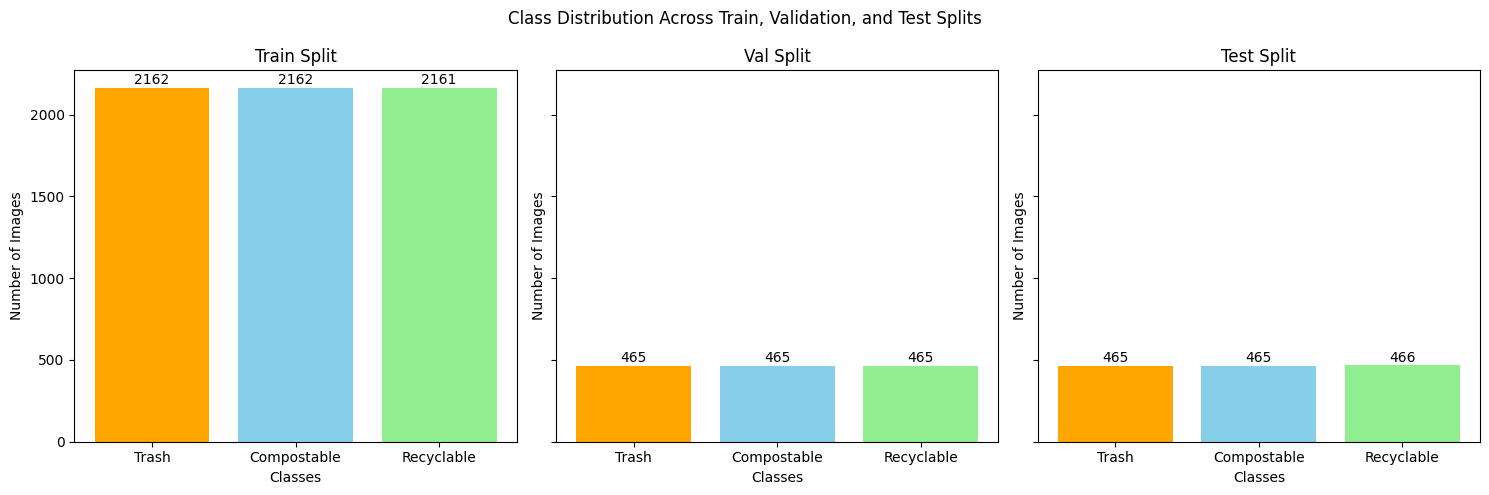

In [9]:
import os
import matplotlib.pyplot as plt

# Path to processed data directory
output_dir = "/content/dataset/processed_uniform"

# Initialize a dictionary to hold counts
split_counts = {'train': {}, 'val': {}, 'test': {}}

# Count images in each split and class
for split in ['train', 'val', 'test']:
    for cls in ['Trash', 'Compostable', 'Recyclable']:
        class_path = os.path.join(output_dir, split, cls)
        count = len([img for img in os.listdir(class_path) if img.endswith(('.jpg', '.png', '.jpeg'))])
        split_counts[split][cls] = count

# Plot the class distribution for each split
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, split in enumerate(['train', 'val', 'test']):
    ax[i].bar(split_counts[split].keys(), split_counts[split].values(), color=["orange", "skyblue", "lightgreen"])
    ax[i].set_title(f"{split.capitalize()} Split")
    ax[i].set_xlabel("Classes")
    ax[i].set_ylabel("Number of Images")
    for j, count in enumerate(split_counts[split].values()):
        ax[i].text(j, count + 5, str(count), ha="center", va="bottom", fontsize=10)

plt.suptitle("Class Distribution Across Train, Validation, and Test Splits")
plt.tight_layout()
plt.show()

# Install Required Libraries

In [10]:
!pip install torch torchvision ftfy regex tqdm transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00


#Load CLIP Pre-Trained Model

In [11]:
import torch
import torch.nn as nn
from transformers import CLIPProcessor, CLIPModel

# Load the CLIP model and processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Freeze the CLIP visual encoder
for param in clip_model.vision_model.parameters():
    param.requires_grad = False

# Add a new classification head
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model.vision_model
        self.fc = nn.Linear(768, num_classes)

    def forward(self, images):
        image_features = self.clip(images).pooler_output
        return self.fc(image_features)


# Initialize the model
num_classes = 3
model = CLIPClassifier(clip_model, num_classes).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

#Preprocess Images and Prepare DataLoader
We need to preprocess the images to make them compatible with the CLIP model.

In [15]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Define preprocessing pipeline (resize, normalize, etc.)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],  # CLIP's mean
                         std=[0.26862954, 0.26130258, 0.27577711])  # CLIP's std
])

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_map = {"Trash": 0, "Compostable": 1, "Recyclable": 2}

        for cls in self.class_map:
            class_path = os.path.join(data_dir, cls)
            for img_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(self.class_map[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load Datasets
train_dataset = ImageDataset("/content/dataset/processed_uniform/train", transform=preprocess)
val_dataset = ImageDataset("/content/dataset/processed_uniform/val", transform=preprocess)
test_dataset = ImageDataset("/content/dataset/processed_uniform/test", transform=preprocess)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Define Loss, Optimizer, and Training Loop
Now define the training components.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation function
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    """
    Train and validate the model while saving metrics.
    """
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train, total_train = 0, 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            total_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)  # Get predictions
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        # Calculate average train loss and accuracy
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation phase
        val_accuracy, val_loss = validate_model(model, val_loader, criterion)

        # Save metrics
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print progress
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

# Validation function
def validate_model(model, loader, criterion):
    """
    Evaluate the model on validation or test data.
    """
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    avg_loss = total_loss / len(loader)
    return accuracy, avg_loss

# Train and validate the model
epochs = 5
train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)

# Save the model
torch.save(model.state_dict(), "clip_trash_classifier_finetuned.pth")
print("Model saved successfully!")

Epoch [1/5], Train Loss: 0.2328, Train Acc: 0.9192, Val Loss: 0.2188, Val Acc: 0.9233
Epoch [2/5], Train Loss: 0.2036, Train Acc: 0.9286, Val Loss: 0.2000, Val Acc: 0.9276
Epoch [3/5], Train Loss: 0.1865, Train Acc: 0.9335, Val Loss: 0.1861, Val Acc: 0.9412
Epoch [4/5], Train Loss: 0.1742, Train Acc: 0.9363, Val Loss: 0.1766, Val Acc: 0.9434
Epoch [5/5], Train Loss: 0.1647, Train Acc: 0.9400, Val Loss: 0.1697, Val Acc: 0.9427
Model saved successfully!


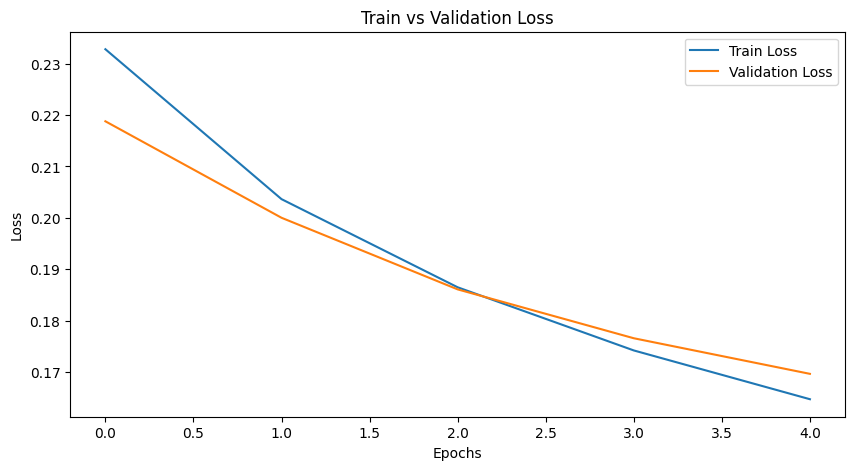

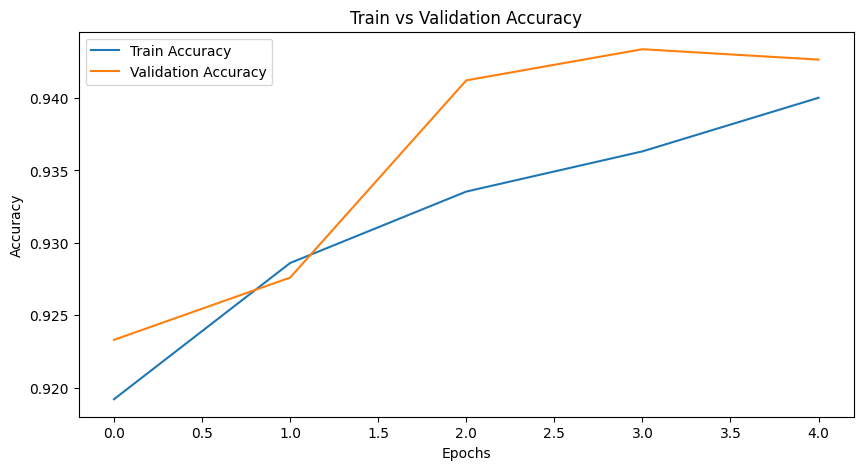

In [17]:
# Plot Train and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Train vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Train and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Train vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
#new
# Function to evaluate model on test data
def evaluate_on_test(model, test_loader, criterion):
    """
    Evaluate the trained model on the test dataset.
    """
    model.eval()  # Set model to evaluation mode
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Calculate test loss and accuracy
    test_accuracy = correct / total
    avg_test_loss = total_loss / len(test_loader)

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return avg_test_loss, test_accuracy

# Evaluate on test data
test_loss, test_accuracy = evaluate_on_test(model, test_loader, criterion)

# Save results for reference
with open("test_results.txt", "w") as file:
    file.write(f"Test Loss: {test_loss:.4f}\n")
    file.write(f"Test Accuracy: {test_accuracy:.4f}\n")

print("Evaluation on test data completed!")

Test Loss: 0.1522, Test Accuracy: 0.9513
Evaluation on test data completed!


In [29]:
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import CLIPModel
from PIL import Image
from google.colab import files

# Define class labels
class_labels = ["Trash", "Compostable", "Recyclable"]

# Define CLIP Classifier (same as used during training)
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model.vision_model
        self.fc = nn.Linear(768, num_classes)

    def forward(self, images):
        image_features = self.clip(images).pooler_output
        return self.fc(image_features)

# Load the CLIP model and classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPClassifier(clip_model, num_classes=3).to(device)

# Load the saved model weights
model.load_state_dict(torch.load("/content/clip_trash_classifier_finetuned.pth", map_location=device))
model.eval()  # Set model to evaluation mode

# Image preprocessing pipeline (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],  # CLIP mean
                         std=[0.26862954, 0.26130258, 0.27577711])  # CLIP std
])

# Function to make predictions
def predict_image(model, image_path):
    """
    Predict the class label of an uploaded image.
    """
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Preprocess image and add batch dimension

    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        confidence, predicted = torch.max(probabilities, dim=0)

    predicted_class = class_labels[predicted.item()]
    confidence_score = confidence.item() * 100

    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence_score:.2f}%")

# Upload an image
uploaded = files.upload()

# Check if the image is uploaded and run prediction
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")
    predict_image(model, filename)

<ipython-input-29-1a93556f9385>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/clip_trash_classifier_finetuned.pth", map_locati

Saving Glass_85.jpg to Glass_85.jpg
Uploaded file: Glass_85.jpg
Predicted Class: Recyclable
Confidence: 96.27%


#confusion matrix on test dataset

Classification Report:
              precision    recall  f1-score   support

       Trash       0.94      0.92      0.93       465
 Compostable       0.96      0.98      0.97       465
  Recyclable       0.96      0.96      0.96       466

    accuracy                           0.95      1396
   macro avg       0.95      0.95      0.95      1396
weighted avg       0.95      0.95      0.95      1396



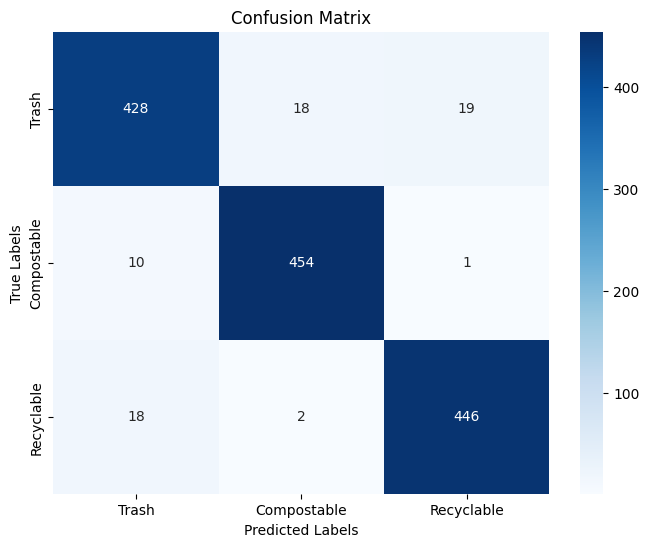

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model and generate predictions
def evaluate_and_plot(model, test_loader, class_labels):
    """
    Evaluate the model on test data, plot confusion matrix, and print classification report.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, preds = torch.max(outputs, 1)  # Get predictions
            all_preds.extend(preds.cpu().numpy())  # Save predictions
            all_labels.extend(labels.cpu().numpy())  # Save true labels

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_labels))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()

# Define class labels
class_labels = ["Trash", "Compostable", "Recyclable"]

# Run evaluation and plot
evaluate_and_plot(model, test_loader, class_labels)

In [24]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from transformers import CLIPModel

# Define class labels
class_labels = ["Trash", "Compostable", "Recyclable"]

# Define the CLIP Classifier
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model.vision_model
        self.fc = nn.Linear(768, num_classes)

    def forward(self, images):
        image_features = self.clip(images).pooler_output
        return self.fc(image_features)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CLIP model and classifier
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
model = CLIPClassifier(clip_model, num_classes=3).to(device)

# Load the saved model weights
model.load_state_dict(torch.load("/content/clip_trash_classifier_finetuned.pth", map_location=device))
model.eval()

# Image preprocessing pipeline (use CLIP normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],  # CLIP mean
                         std=[0.26862954, 0.26130258, 0.27577711])  # CLIP std
])

# Prediction function
def predict_image(image_path):
    """
    Predicts the class of the input image.
    """
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Model inference
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
            confidence, predicted = torch.max(probabilities, dim=0)

        # Get results
        predicted_class = class_labels[predicted.item()]
        confidence_score = confidence.item() * 100

        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {confidence_score:.2f}%")
        return predicted_class, confidence_score
    except Exception as e:
        print(f"Error: {str(e)}. Please check the image file path.")
        return None, None

# Test the model on an input image
image_path = "/content/dataset/processed_uniform/test/Trash/Miscellaneous Trash_405.jpg"  # Replace with the actual image path
predicted_class, confidence = predict_image(image_path)

<ipython-input-24-4da20a6d0daa>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/clip_trash_classifier_finetuned.pth", map_locati

Predicted Class: Trash
Confidence: 96.99%


In [30]:
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
local_model_path = "/content/clip_trash_classifier_finetuned.pth"  # Path of the saved model in Colab
drive_model_path = "/content/drive/MyDrive/clip_trash_classifier_finetuned.pth"  # Destination in Google Drive

# Copy the model to Google Drive
if os.path.exists(local_model_path):
    shutil.copy(local_model_path, drive_model_path)
    print(f"Model successfully saved to Google Drive at: {drive_model_path}")
else:
    print("Model file not found. Please ensure the path is correct.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model successfully saved to Google Drive at: /content/drive/MyDrive/clip_trash_classifier_finetuned.pth


for gradio

In [3]:
!pip install gradio torch torchvision transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


#app.py

In [6]:
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import CLIPModel
from PIL import Image
import gradio as gr

# Define class labels
class_labels = ["Trash", "Compostable", "Recyclable"]

# Define CLIP Classifier (same as used during training)
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model.vision_model
        self.fc = nn.Linear(768, num_classes)

    def forward(self, images):
        image_features = self.clip(images).pooler_output
        return self.fc(image_features)

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPClassifier(clip_model, num_classes=3).to(device)

# Load the saved weights
model.load_state_dict(torch.load("/content/drive/MyDrive/clip_trash_classifier_finetuned.pth", map_location=device))
model.eval()

# Preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],  # CLIP's mean
                         std=[0.26862954, 0.26130258, 0.27577711])  # CLIP's std
])

# Prediction function
def predict(image):
    """
    Function to predict the class label and confidence of the uploaded image.
    Returns separate values for label and confidence.
    """
    # Preprocess the image
    image = transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        confidence, predicted = torch.max(probabilities, dim=0)

    # Get predicted class and confidence score
    predicted_class = class_labels[predicted.item()]
    confidence_score = f"{confidence.item() * 100:.2f}%"

    # Return as separate outputs
    return predicted_class, confidence_score

# Gradio Interface
interface = gr.Interface(
    fn=predict,                    # Prediction function
    inputs=gr.Image(type="pil"),   # Input: Image in PIL format
    outputs=[
        gr.Textbox(label="Predicted Category"),  # Output 1: Predicted Label
        gr.Textbox(label="Confidence")           # Output 2: Confidence Score
    ],
    title="Trash Classifier Using CLIP",
    description="Upload an image to classify it as **Trash**, **Compostable**, or **Recyclable**.\n"
                "The app will display the predicted category and confidence score."
)

# Launch the app
if __name__ == "__main__":
    interface.launch(share=True)

<ipython-input-6-f4f1294fb457>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/clip_trash_classifier_finetuned.pth

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3cb498c807d236c42e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [9]:
import shutil
# Source and destination paths
source_path = "/content/drive/MyDrive/clip_trash_classifier_finetuned.pth"  # Model in Drive
destination_path = "/content/clip_trash_classifier_finetuned.pth"          # Copy to Colab's root directory

# Copy the file
shutil.copy(source_path, destination_path)

print(f"Model file copied successfully to: {destination_path}")

Model file copied successfully to: /content/clip_trash_classifier_finetuned.pth


#UPTLL HERE IT IS ALL DONE RIGHT NOW


#gradio application making


In [ ]:
!pip install gradio torch torchvision transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import CLIPModel

# Define class labels
class_labels = ["Compostable", "Trash", "Recyclable"]

# Define the model architecture
class CLIPClassifier(torch.nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model.vision_model
        self.fc = torch.nn.Linear(768, num_classes)  # 768 for ViT-B/32

    def forward(self, images):
        image_features = self.clip(images).pooler_output
        return self.fc(image_features)

# Load CLIP model and your trained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Load trained model
model = CLIPClassifier(clip_model, num_classes=3).to(device)
model.load_state_dict(torch.load("/content/clip_trash_classifier.pth", map_location=device))
model.eval()

print("Model loaded successfully!")

<ipython-input-20-4f701e506bc2>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/clip_trash_classifier.pth", map_location=device)

Model loaded successfully!


In [ ]:
# Image preprocessing (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

import torch.nn.functional as F

def predict(image):
    """
    Function to preprocess input image, run inference, and return predicted class with confidence.
    """
    # Preprocess the image
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Run inference
    with torch.no_grad():
        outputs = model(image)  # Raw logits
        probabilities = F.softmax(outputs, dim=1)  # Convert to probabilities
        confidence, predicted = torch.max(probabilities, 1)  # Get max confidence and predicted class

    # Extract values
    predicted_class = class_labels[predicted.item()]
    confidence_score = confidence.item() * 100  # Convert to percentage

    return f"Predicted Class: {predicted_class} (Confidence: {confidence_score:.2f}%)"


In [ ]:
import gradio as gr

interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(label="Prediction"),
    title="Trash Classifier with CLIP",
    description="Upload an image to classify it as Recyclable, Trash, or Compostable, along with the confidence score."
)

interface.launch(share=True)



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c47fdbdf34830829c2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#Enhance Data Preparation and Augmentation
a) Advanced Data Augmentation
Use advanced augmentations to make your model more robust to variations in images:

Random transformations: rotation, flipping, cropping, and color jitter.
CutMix and MixUp: Blend images and labels to reduce overfitting.
Noise Injection: Add Gaussian noise for robustness.

In [ ]:
import torchvision.transforms as transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


#Fine-Tune More CLIP Layers
Currently, only the linear head is being fine-tuned. To extract more powerful features, unfreeze the last 2 layers of CLIP's visual encoder.

In [ ]:
import torch
import torch.nn as nn
from transformers import CLIPModel

# Define CLIP Classifier with partial unfreezing
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model.vision_model
        self.fc = nn.Linear(768, num_classes)  # 768 output size for ViT-B/32

        # Unfreeze only the last 2 layers of the CLIP visual encoder
        for name, param in self.clip.named_parameters():
            if "encoder.layers" in name and int(name.split(".")[2]) >= 10:  # Last 2 layers
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, images):
        image_features = self.clip(images).pooler_output  # Extract image embeddings
        return self.fc(image_features)

#Initialize Model, Optimizer, and Loss Function
Load the pretrained CLIP model, initialize the classifier, and set up the optimizer and loss function.

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Load pretrained CLIP model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Initialize your model
num_classes = 3
model = CLIPClassifier(clip_model, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# Data transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
data_dir = "/content/dataset/processed"
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=train_transforms)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


#Training Function with Saved Metrics
Here, we save the train loss, validation loss, train accuracy, and validation accuracy in lists for plotting.

In [ ]:
import matplotlib.pyplot as plt

# Lists to save loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training Phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Save the model after training
    torch.save(model.state_dict(), "clip_trash_classifier_finetuned.pth")
    print("Model saved successfully!")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)


Epoch [1/5], Train Loss: 0.2715, Train Accuracy: 89.88%, Val Loss: 0.1986, Val Accuracy: 91.87%
Epoch [2/5], Train Loss: 0.1055, Train Accuracy: 96.05%, Val Loss: 0.1627, Val Accuracy: 93.55%
Epoch [3/5], Train Loss: 0.0664, Train Accuracy: 97.56%, Val Loss: 0.1452, Val Accuracy: 94.67%
Epoch [4/5], Train Loss: 0.0491, Train Accuracy: 98.34%, Val Loss: 0.1331, Val Accuracy: 94.95%
Epoch [5/5], Train Loss: 0.0348, Train Accuracy: 98.84%, Val Loss: 0.1229, Val Accuracy: 95.37%
Model saved successfully!


#Plot Training and Validation Metrics
After training, use the saved metrics to plot loss and accuracy curves.

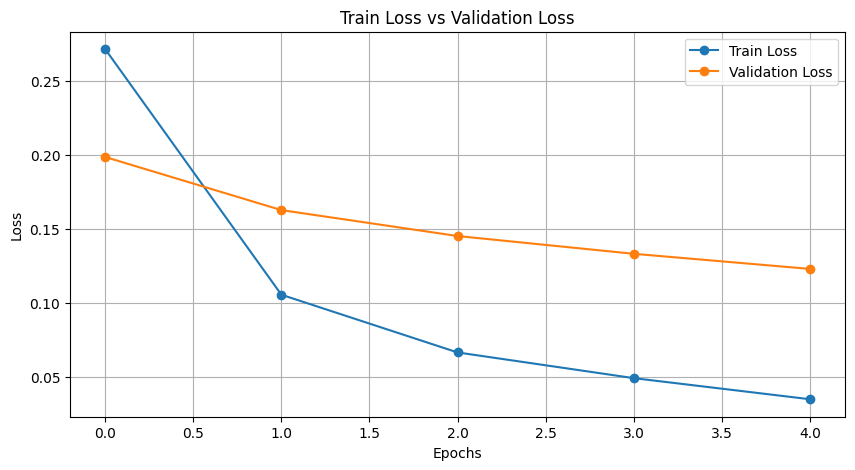

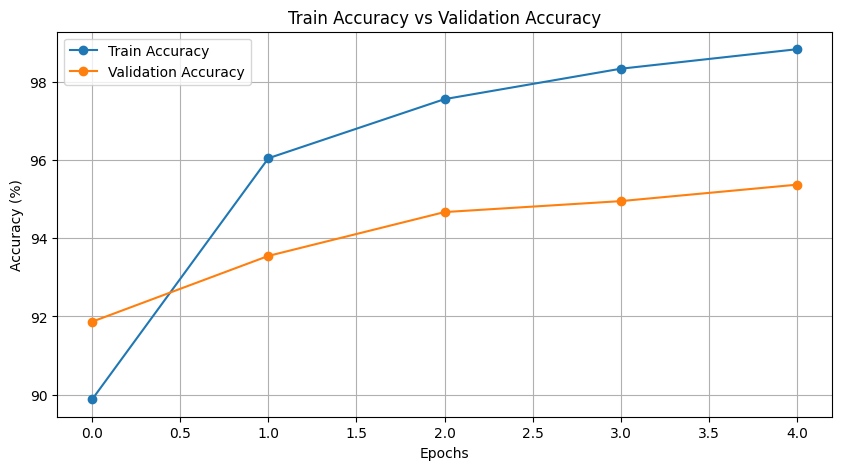

In [ ]:
# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train Loss vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy", marker='o')
plt.plot(val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train Accuracy vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Reload the model for evaluation
model = CLIPClassifier(clip_model, num_classes).to(device)
model.load_state_dict(torch.load("clip_trash_classifier_finetuned.pth", map_location=device))
model.eval()

print("Model loaded successfully for test evaluation.")


<ipython-input-31-b55e86d075a1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("clip_trash_classifier_finetuned.pth", map_location=device)

Model loaded successfully for test evaluation.


Test Accuracy: 95.94%


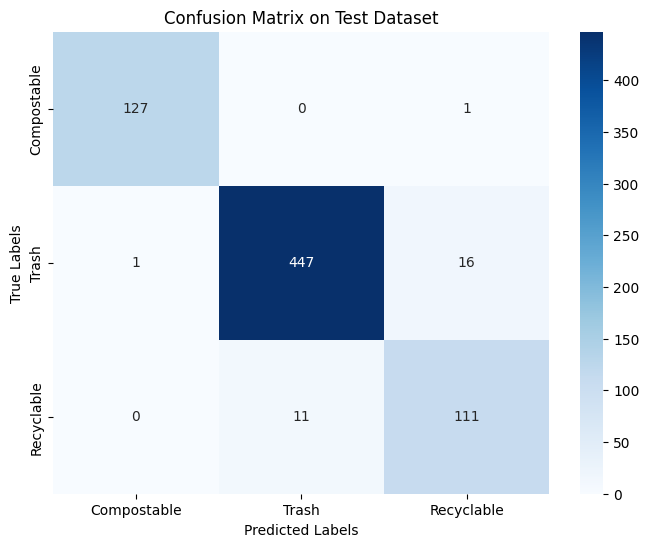


Classification Report:

              precision    recall  f1-score   support

 Compostable       0.99      0.99      0.99       128
       Trash       0.98      0.96      0.97       464
  Recyclable       0.87      0.91      0.89       122

    accuracy                           0.96       714
   macro avg       0.95      0.96      0.95       714
weighted avg       0.96      0.96      0.96       714



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load Test Dataset
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate on Test Dataset
def evaluate_on_test(model, test_loader, class_labels):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Accuracy
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix on Test Dataset")
    plt.show()

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_labels))

# Class names
class_labels = ["Compostable", "Trash", "Recyclable"]

# Evaluate the model
evaluate_on_test(model, test_loader, class_labels)


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import CLIPModel
from PIL import Image
import gradio as gr

# Define class labels
class_labels = ["Compostable", "Trash", "Recyclable"]

# Define CLIP Classifier
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model.vision_model
        self.fc = nn.Linear(768, num_classes)  # 768 output size for ViT-B/32

    def forward(self, images):
        image_features = self.clip(images).pooler_output
        return self.fc(image_features)


# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Initialize and load the fine-tuned model
model = CLIPClassifier(clip_model, num_classes=3).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/saved_models/clip_trash_classifier_finetuned.pth", map_location=device))
model.eval()

# Image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Prediction function with confidence for all classes
def predict(image):
    """
    Function to classify an image into Compostable, Trash, or Recyclable.
    Displays confidence scores for all classes.
    """
    try:
        # Preprocess image
        image = transform(image).unsqueeze(0).to(device)

        # Model inference
        with torch.no_grad():
            outputs = model(image)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

        # Class-wise confidence scores
        confidence_scores = {class_labels[i]: f"{prob.item() * 100:.2f}%" for i, prob in enumerate(probabilities)}

        # Predicted class
        confidence, predicted = torch.max(probabilities, dim=0)
        predicted_class = class_labels[predicted.item()]
        confidence_score = confidence.item() * 100

        # Output
        result = f"**Predicted Class**: {predicted_class}\n**Confidence**: {confidence_score:.2f}%\n\n"
        result += "**Class-wise Confidence Scores**:\n"
        for label, score in confidence_scores.items():
            result += f"- {label}: {score}\n"

        return result
    except Exception as e:
        return f"Error: {str(e)}. Please upload a valid image."


# Gradio Interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),  # Input: Image as PIL format
    outputs=gr.Markdown(),  # Output: Formatted text with Markdown
    title="Enhanced Trash Classifier Using CLIP",
    description="Upload an image to classify it as **Compostable**, **Trash**, or **Recyclable**.\n"
                "The application will also display confidence scores for all classes.",
    examples=[
        ["example/compostables.jpg"],
        ["example/trash.jpg"],
        ["example/recyclables.jpg"]
    ]
)

# Launch the app
if __name__ == "__main__":
    interface.launch(share=True)


<ipython-input-10-266d2cebd886>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/saved_models/clip_trash_classifier

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e1d8f85bc600213e23.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import shutil

# Define paths
local_processed_dataset = "/content/dataset/processed"
drive_processed_dataset = "/content/drive/MyDrive/processed_dataset"

# Copy the processed dataset to Google Drive
shutil.copytree(local_processed_dataset, drive_processed_dataset)

print(f"Processed dataset saved to: {drive_processed_dataset}")


Processed dataset saved to: /content/drive/MyDrive/processed_dataset


In [ ]:
import os
import shutil

# Define paths
model_files = ["clip_trash_classifier_finetuned.pth"]  # List of model files to save
drive_model_folder = "/content/drive/MyDrive/saved_models"

# Create the folder in Drive if it doesn't exist
os.makedirs(drive_model_folder, exist_ok=True)

# Copy model files to Google Drive
for model_file in model_files:
    local_path = os.path.join("/content", model_file)
    drive_path = os.path.join(drive_model_folder, model_file)
    shutil.copy(local_path, drive_path)
    print(f"Model file saved to: {drive_path}")

print("All model files saved to Google Drive.")

Model file saved to: /content/drive/MyDrive/saved_models/clip_trash_classifier_finetuned.pth
All model files saved to Google Drive.


converted the file to app.py

In [ ]:
%%writefile app.py
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import CLIPModel
from PIL import Image
import gradio as gr

# Define class labels
class_labels = ["Compostable", "Trash", "Recyclable"]

# Define CLIP Classifier
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CLIPClassifier, self).__init__()
        self.clip = clip_model.vision_model
        self.fc = nn.Linear(768, num_classes)  # 768 output size for ViT-B/32

    def forward(self, images):
        image_features = self.clip(images).pooler_output
        return self.fc(image_features)


# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Initialize and load the fine-tuned model
model = CLIPClassifier(clip_model, num_classes=3).to(device)
model.load_state_dict(torch.load("clip_trash_classifier_finetuned.pth", map_location=device))
model.eval()

# Image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Prediction function with confidence for all classes
def predict(image):
    """
    Function to classify an image into Compostable, Trash, or Recyclable.
    Displays confidence scores for all classes.
    """
    try:
        # Preprocess image
        image = transform(image).unsqueeze(0).to(device)

        # Model inference
        with torch.no_grad():
            outputs = model(image)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

        # Class-wise confidence scores
        confidence_scores = {class_labels[i]: f"{prob.item() * 100:.2f}%" for i, prob in enumerate(probabilities)}

        # Predicted class
        confidence, predicted = torch.max(probabilities, dim=0)
        predicted_class = class_labels[predicted.item()]
        confidence_score = confidence.item() * 100

        # Output
        result = f"**Predicted Class**: {predicted_class}\\n**Confidence**: {confidence_score:.2f}%\\n\\n"
        result += "**Class-wise Confidence Scores**:\\n"
        for label, score in confidence_scores.items():
            result += f"- {label}: {score}\\n"

        return result
    except Exception as e:
        return f"Error: {str(e)}. Please upload a valid image."


# Gradio Interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),  # Input: Image as PIL format
    outputs=gr.Markdown(),  # Output: Formatted text with Markdown
    title="Enhanced Trash Classifier Using CLIP",
    description="Upload an image to classify it as **Compostable**, **Trash**, or **Recyclable**.\\n"
                "The application will also display confidence scores for all classes.",
    examples=[
        ["examples/compostables.jpg"],
        ["examples/trash.jpg"],
        ["examples/recyclables.jpg"]
    ]
)

# Launch the app
if __name__ == "__main__":
    interface.launch(share=True)


Overwriting app.py


#deploying it to huggingface spaces

In [33]:
%cd /content

/content


In [34]:
!git clone https://huggingface.co/spaces/pjohn2409/Waste-sort

Cloning into 'Waste-sort'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (4/4), 1.27 KiB | 144.00 KiB/s, done.


In [35]:
# Set Git config for Hugging Face
!git config --global user.email "email-id"   # Replace with your email
!git config --global user.name "username"                 # Replace with your Hugging Face username

In [11]:
!git clone https://huggingface.co/spaces/pjohn2409/wasteClassifierLVM

Cloning into 'wasteClassifierLVM'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 35 (delta 12), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (35/35), 427.75 KiB | 4.41 MiB/s, done.


In [36]:
!pip install huggingface_hub

In [37]:
from huggingface_hub import login
login()


In [38]:
%cd Waste-sort

/content/Waste-sort


In [25]:
!git rm --cached clip_trash_classifier_finetuned.pth

rm 'clip_trash_classifier_finetuned.pth'


In [39]:
!apt-get install git-lfs
!git lfs install

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Updated git hooks.
Git LFS initialized.


In [40]:
!git lfs track "*.pth"
!git add .gitattributes

"*.pth" already supported


In [42]:
!git add .

In [43]:
!git commit -m "Initial commit"

[main 48ce321] Initial commit
 6 files changed, 84 insertions(+)
 create mode 100644 app.py
 create mode 100644 clip_trash_classifier_finetuned.pth
 create mode 100644 examples/compostables.jpg
 create mode 100644 examples/recyclables.jpg
 create mode 100644 examples/trash.jpg
 create mode 100644 requirements.txt


In [44]:
!git push origin main

Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 2 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 419.52 KiB | 13.98 MiB/s, done.
Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
To https://huggingface.co/spaces/pjohn2409/Waste-sort
   1b8115b..48ce321  main -> main
